# Problem Statement





ERC is a task that aims at predicting emotion of each utterance in a conversation. The following is an excerpt of a conversation with each utterance tagged with corresponding emotion and sentiment label.

![alt text](example.jpg "Title")


# Hierarchical Transformer Network for Utterance-Level Emotion Recognition
This is the Pytorch implementation Utterance-level Emotion Recognition [paper](https://arxiv.org/ftp/arxiv/papers/2002/2002.07551.pdf)

Overview
Though predicting the emotion of a single utterance or sentence, i.e. emotion detection, is a well discussed subject in natural language understanding literature, EmoContext has several novel challenges. In this paper, we address four challenges in utterance-level emotion recognition in dialogue systems:

- Emotion depend on the context of previous utterances in the dialogue

- long-range contextual information is hard to be effectively captured;

- Datasets are quite small.

- the class distribution of training data is significantly different from that of the test data. Consequently, a model trained on the training data might not perform well on the test data.

- We propose a hierarchical transformer framework with a lower-level transformer to model the word-level inputs and an upper-level transformer to capture the contexts of utterance-level embeddings.

In [ ]:
Train Set: Utterance length statistics : Min: 1, Max: 69 Avg: 7.79
Train Set: Utterance length statistics : Min: 1, Max: 37 Avg: 7.7
Train Set: Utterance length statistics : Min: 1, Max: 45 Avg: 8.02

# Dataset
Dataset includes the training data set consisting of 720 dialogues, and two evaluation data sets, Dev and Test, containing
80 and 200 dialogues respectively. The Training, validation and test datasets are json files containing following information :

 - Speaker - Identifies the speaker of utterance
 - Utterance -  The textual content of the utterance.
 - Emotion - Emotion labels for each utterance
 - Annotation - The annotation string contains the raw count of votes for each emotion by the annotators. The order of the emotions in the string is [neutral, joy, sadness, fear, anger,  surprise, disgust]. For example, string "2000030" denotes that two annotators voted for "neutral", and three voted for "surprise". Note that the sum of the votes is always five, since the dialogues were annotated by five annotators.

Dataset stattistics:


| Statistics | Train | Dev | Test | 
| :-| :- | :- | :- | 
| # of Dialogues | 720 | 80 |200 | 
| # of Utterances | 10561 | 1178 |2764 | 
| Min number of Utterances per dialogue| 5 | 5 |5 | 
| Max number of Utterances per dialogue| 24 | 24 |24 | 
| Average number of Utterances per dialogue| 14.67 | 14.72 |13.82 | 
| Min Utterance length | 1 | 1 |1 | 
| Max Utterance length | 69 | 37 |45 | 
| Average Utterance length | 7.79 | 7.7 |8.02 | 



    
    

In [8]:
import torch
import os
import random
import pandas as pd
import functools
import time
import math
import argparse
import json


from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from ipywidgets import interact
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from transformers import DistilBertModel, DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer

from collections import defaultdict
from sklearn.metrics import f1_score
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Read Dataset CSV Files

In [11]:
path = 'data/Friends/friends.train.json'
with open(path, encoding='utf-8') as data_file:
    train_json = json.loads(data_file.read())
path = 'data/Friends/friends.dev.json'
with open(path, encoding='utf-8') as data_file:
    val_json = json.loads(data_file.read())
path = 'data/Friends/friends.test.json'
with open(path, encoding='utf-8') as data_file:
    test_json = json.loads(data_file.read())

In [12]:
train_json[0:3]

[[{'speaker': 'Chandler',
   'utterance': "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
   'emotion': 'neutral',
   'annotation': '4100000'},
  {'speaker': 'The Interviewer',
   'utterance': "You must've had your hands full.",
   'emotion': 'neutral',
   'annotation': '5000000'},
  {'speaker': 'Chandler',
   'utterance': 'That I did. That I did.',
   'emotion': 'neutral',
   'annotation': '5000000'},
  {'speaker': 'The Interviewer',
   'utterance': "So let's talk a little bit about your duties.",
   'emotion': 'neutral',
   'annotation': '5000000'},
  {'speaker': 'Chandler',
   'utterance': 'My duties?  All right.',
   'emotion': 'surprise',
   'annotation': '2000030'},
  {'speaker': 'The Interviewer',
   'utterance': "Now you'll be heading a whole division, so you'll have a lot of duties.",
   'emotion': 'neutral',
   'annotation': '5000000'},
  {'speaker': 'Chandler',
   'utterance': 'I see.',
   'emotion': 'neutral',
   'annotation': '310001

In [13]:
def create_df(data, column_list):
    df = pd.DataFrame(columns = column_list)
    dialogue_idx = 0
    for dialog in data:
        for utter in dialog:
            df2 = pd.DataFrame([[dialogue_idx, utter['utterance'], utter['speaker'], len(utter['utterance'].split()), utter['emotion'] ]], columns = column_list)
            df = df.append(df2, ignore_index=True)
        dialogue_idx += 1
        '''
        if (dialogue_idx == 20):  # Load less data for test run
            break
        '''
    return df
    

In [14]:
column_list = list(('dialogue_id', 'utterance', 'speaker','utterance_len', 'label'))
df_train = create_df(train_json, column_list )
df_val = create_df(val_json, column_list )       
df_test = create_df(test_json, column_list )   

#  Number of Dialogues in Training and Evaluation Sets

In [15]:
len(df_train['dialogue_id'].unique()), len(df_val['dialogue_id'].unique()), len(df_test['dialogue_id'].unique())

(720, 80, 200)

In [16]:
df_train

,dialogue_id,utterance,speaker,utterance_len,label
0,0,also I was the point person on my company's tr...,Chandler,16,neutral
1,0,You must've had your hands full.,The Interviewer,6,neutral
2,0,That I did. That I did.,Chandler,6,neutral
3,0,So let's talk a little bit about your duties.,The Interviewer,9,neutral
4,0,My duties? All right.,Chandler,4,surprise
...,...,...,...,...,...
10556,719,You or me?,Chandler,3,neutral
10557,719,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,10,non-neutral
10558,719,"You guys are messing with me, right?",Joey,7,surprise
10559,719,Yeah.,All,1,neutral


#  Number of utterances in Training and Evaluation Sets

In [17]:
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(10561, 1178, 2764)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10561 entries, 0 to 10560
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dialogue_id    10561 non-null  object
 1   utterance      10561 non-null  object
 2   speaker        10561 non-null  object
 3   utterance_len  10561 non-null  object
 4   label          10561 non-null  object
dtypes: object(5)
memory usage: 412.7+ KB


In [19]:
df_train['label'].value_counts(), df_val['label'].value_counts(), df_test['label'].value_counts()

(neutral        4752
 non-neutral    2017
 joy            1283
 surprise       1220
 anger           513
 sadness         351
 disgust         240
 fear            185
 Name: label, dtype: int64,
 neutral        491
 non-neutral    214
 surprise       151
 joy            123
 anger           85
 sadness         62
 fear            29
 disgust         23
 Name: label, dtype: int64,
 neutral        1287
 non-neutral     541
 joy             304
 surprise        286
 anger           161
 sadness          85
 disgust          68
 fear             32
 Name: label, dtype: int64)

#  Comparison of class distribution in Training vs Evaluation data sets

| Emotion | Neutral | Non-Neutral | Joy | Surprise | Anger | Sadness | Disgust | Fear | # |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Train | 4752 | 2017 |1283 | 1220| 513|351 |240 | 185| 10561|
| Dev | 491 | 214 |151 | 123| 85|62 |29 | 23| 1178|
| Test | 1287 | 541 |304 | 286| 161|85 |68 | 32| 2764|

In [20]:
data = [df_train['label'], df_val['label'], df_test['label']]
columns=list(('Training', 'Validation', 'Test'))
df_labels = pd.concat(data, axis=1, keys=columns)

In [21]:
set(df_train.label)

{'anger',
 'disgust',
 'fear',
 'joy',
 'neutral',
 'non-neutral',
 'sadness',
 'surprise'}

[Text(0, 0, 'joy'),
 Text(1, 0, 'surprise'),
 Text(2, 0, 'anger'),
 Text(3, 0, 'sadness'),
 Text(4, 0, 'disgust'),
 Text(5, 0, 'fear'),
 Text(6, 0, 'non-neutral'),
 Text(7, 0, 'neutral')]

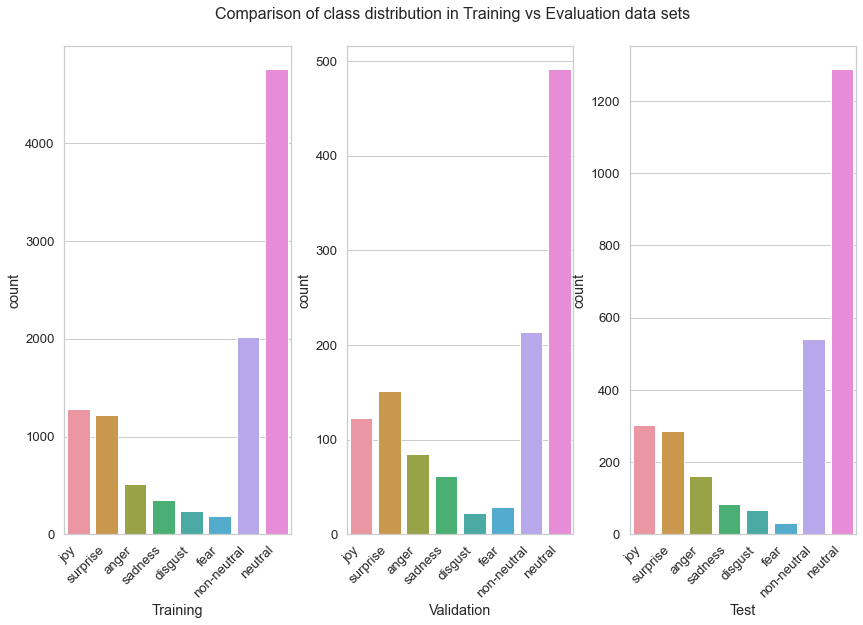

In [22]:
fig, ax =plt.subplots(1,3)
fig.suptitle('Comparison of class distribution in Training vs Evaluation data sets', fontsize=16)
fig.tight_layout()
emotion_list = ['joy', 'surprise', 'anger', 'sadness','disgust', 'fear', 'non-neutral', 'neutral' ]
chart = sns.countplot(x="Training",   data=df_labels, order = emotion_list, ax=ax[0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Validation", data=df_labels, order = emotion_list, ax=ax[1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Test",       data=df_labels, order = emotion_list, ax=ax[2])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# Scale of class imbalance is different in Training and Evaluation data sets
| Emotion | Neutral | Non-Neutral | Joy | Surprise | Anger | Sadness | Disgust | Fear |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Train | 45% | 19% |12% | 12%| 5% |3% |2% | 2%| 
| Dev | 42% | 18% |13% | 10%| 7%|5% |3% | 2%|
| Test | 46% | 20% |11% | 10%| 6%|3% |3% | 1%|

Distribution of classes is almost similar among training and eval sets

In [32]:
train = pd.Series(['Training'] , ['name'])
train = train.append(df_labels['Training'].value_counts().div(df_labels['Training'].value_counts().sum()))
val = pd.Series(['Validation'] , ['name'])
val = val.append(df_labels['Validation'].value_counts().div(df_labels['Validation'].value_counts().sum()))
test = pd.Series(['Test'] , ['name'])
test = test.append(df_labels['Test'].value_counts().div(df_labels['Test'].value_counts().sum()))

df_stacked = pd.DataFrame(columns = emotion_list)

df_stacked = df_stacked.append(train,ignore_index=True)
df_stacked = df_stacked.append(val,ignore_index=True)
df_stacked = df_stacked.append(test,ignore_index=True)

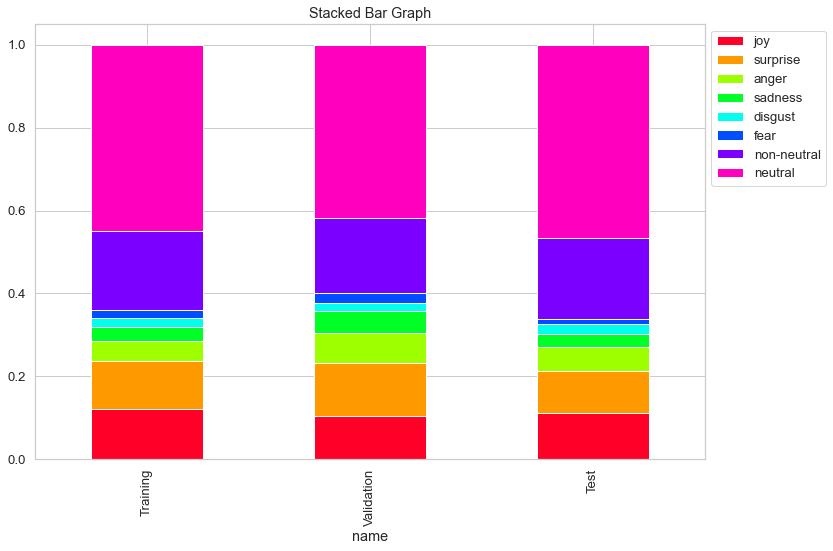

In [33]:
# plot a Stacked Bar Chart using matplotlib
df_stacked.plot(
    x = 'name',
    kind = 'bar',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = False, 
    colormap='gist_rainbow'
   ).legend(bbox_to_anchor=(1, 1))

# Distribution of number of utterances per dialogue in Train and Evaluation Sets
- Minimum and maximum value of number of utterances per dialogue is same across 3 sets, 5 and 24 respectively


In [34]:
train_dialogue_id_list = list((df_train['dialogue_id'].unique()))
val_dialogue_id_list = list((df_val['dialogue_id'].unique()))
test_dialogue_id_list = list((df_test['dialogue_id'].unique()))
d = {"Training":[],"Validation":[],"Test":[] };
for dialogue in train_dialogue_id_list:
     d['Training'].append((df_train.dialogue_id ==dialogue).sum())
for dialogue in val_dialogue_id_list:
     d['Validation'].append((df_val.dialogue_id ==dialogue).sum())
for dialogue in test_dialogue_id_list:
     d['Test'].append((df_test.dialogue_id ==dialogue).sum())




In [35]:

print('Train Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Training']), max(d['Training']), np.round(sum(d['Training'])/len(d['Training']), 2)))
print('Train Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Validation']), max(d['Validation']), np.round(sum(d['Validation'])/len(d['Validation']), 2)))
print('Train Set: Utterance per dialogue statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Test']), max(d['Test']), np.round(sum(d['Test'])/len(d['Test']), 2)))

Train Set: Utterance per dialogue statistics : Min: 5, Max: 24 Avg: 14.67
Train Set: Utterance per dialogue statistics : Min: 5, Max: 24 Avg: 14.72
Train Set: Utterance per dialogue statistics : Min: 5, Max: 24 Avg: 13.82


<AxesSubplot:title={'center':'Test'}, ylabel='Count'>

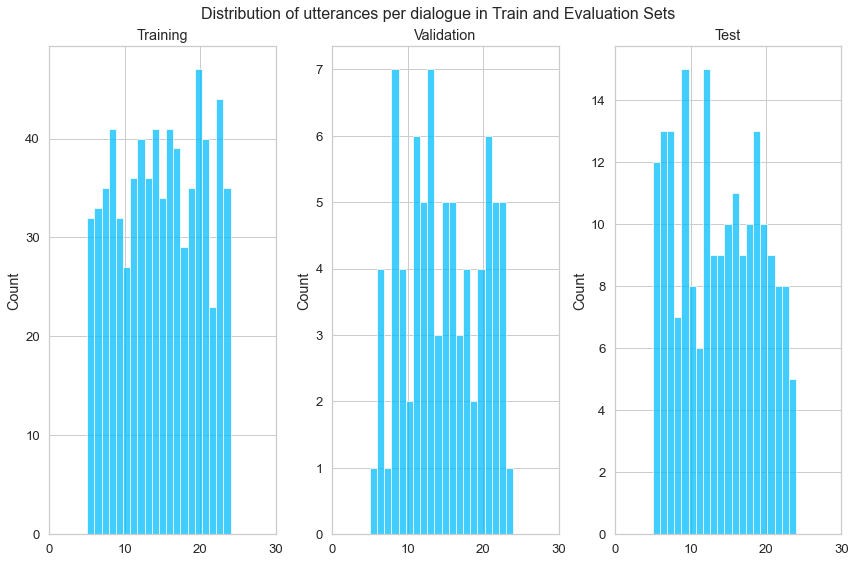

In [36]:
fig, ax =plt.subplots(ncols=3)
fig.suptitle('Distribution of utterances per dialogue in Train and Evaluation Sets', fontsize=16)
fig.tight_layout()
ax[0].set_title('Training')
ax[0].set_xlim([0, 30])
sns.histplot(d['Training'] , ax=ax[0], bins=20, stat = 'count' )

ax[1].set_title('Validation')
ax[1].set_xlim([0, 30])
sns.histplot(d['Validation'] , ax=ax[1], bins=20, stat = 'count')

ax[2].set_title('Test')
ax[2].set_xlim([0, 30])
sns.histplot(d['Test'] , ax=ax[2], bins=20, stat = 'count')


# Distribution of Utterance Length in Train and Evaluation Sets
- Length of utterances follows almost similar distribution in train and evaluation datasets
- Max seq len can be taken around 35


In [38]:
d = {"Training":[],"Validation":[],"Test":[] }

d['Training'] = list(df_train['utterance_len'].values)
d['Validation'] = list(df_val['utterance_len'].values)
d['Test'] = list(df_test['utterance_len'].values)

Minimum and maximum value of utterance length in train, val and test sets

In [39]:
 min(d['Training']), max(d['Training']),  min(d['Validation']), max(d['Validation']),  min(d['Test']), max(d['Test'])

(1, 69, 1, 37, 1, 45)

In [40]:
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Training']), max(d['Training']), np.round(sum(d['Training'])/len(d['Training']), 2)))
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Validation']), max(d['Validation']), np.round(sum(d['Validation'])/len(d['Validation']), 2)))
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Test']), max(d['Test']), np.round(sum(d['Test'])/len(d['Test']), 2)))

Train Set: Utterance length statistics : Min: 1, Max: 69 Avg: 7.79
Train Set: Utterance length statistics : Min: 1, Max: 37 Avg: 7.7
Train Set: Utterance length statistics : Min: 1, Max: 45 Avg: 8.02


In [35]:
for i in range(70):
    print('value = {}, value_Count = {}'.format(i,d['Test'].count(i) ))

value = 0, value_Count = 0
value = 1, value_Count = 373
value = 2, value_Count = 212
value = 3, value_Count = 223
value = 4, value_Count = 214
value = 5, value_Count = 212
value = 6, value_Count = 162
value = 7, value_Count = 157
value = 8, value_Count = 152
value = 9, value_Count = 124
value = 10, value_Count = 136
value = 11, value_Count = 118
value = 12, value_Count = 76
value = 13, value_Count = 77
value = 14, value_Count = 77
value = 15, value_Count = 65
value = 16, value_Count = 72
value = 17, value_Count = 42
value = 18, value_Count = 59
value = 19, value_Count = 43
value = 20, value_Count = 23
value = 21, value_Count = 29
value = 22, value_Count = 31
value = 23, value_Count = 23
value = 24, value_Count = 18
value = 25, value_Count = 7
value = 26, value_Count = 9
value = 27, value_Count = 9
value = 28, value_Count = 6
value = 29, value_Count = 4
value = 30, value_Count = 2
value = 31, value_Count = 1
value = 32, value_Count = 1
value = 33, value_Count = 1
value = 34, value_Count

<AxesSubplot:title={'center':'Test'}, ylabel='Count'>

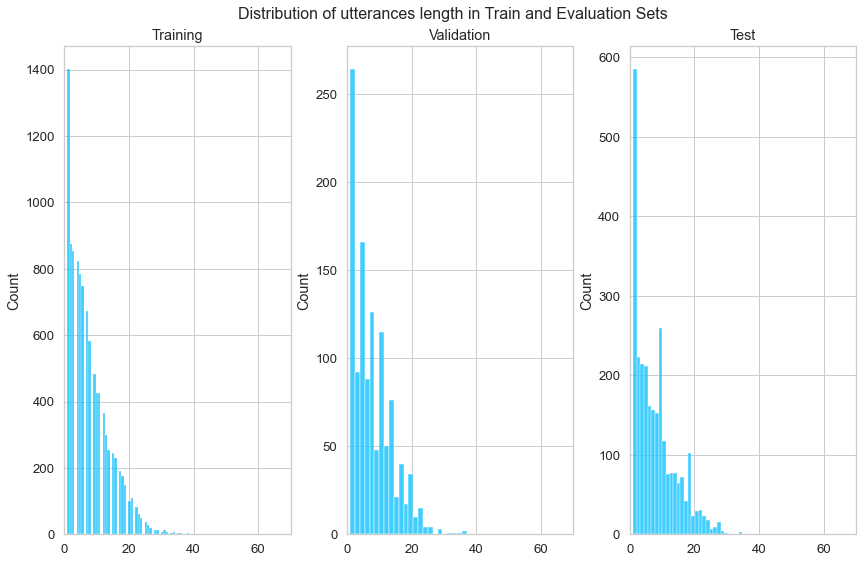

In [36]:
fig, ax =plt.subplots(ncols=3)
fig.suptitle('Distribution of utterances length in Train and Evaluation Sets', fontsize=16)
fig.tight_layout()
ax[0].set_title('Training')
ax[0].set_xlim([0, 70])
sns.histplot(d['Training'] , ax=ax[0], stat = 'count' )

ax[1].set_title('Validation')
ax[1].set_xlim([0, 70])
sns.histplot(d['Validation'] , ax=ax[1], stat = 'count')

ax[2].set_title('Test')
ax[2].set_xlim([0, 70])
sns.histplot(d['Test'] , ax=ax[2],  stat = 'count')


# Data Preprocessing

Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are using BERT for modelling the word level inputs, we need to do following preprocessing

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

We will use the pretrained bert model and tokenizers from the Transformers Library 

In [7]:
def transform_data(df, max_seq_len):
    """
    returns the padded input ids and attention masks according to the DistilBert tokenizer
    """
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    
    def tokenize_fct(turn):
        return tokenizer.encode(turn, truncation = True, add_special_tokens=True, max_length=max_seq_len)
    
    tokenized = df[['utterance']].applymap(tokenize_fct)
    padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
    attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
    return padded, attention_mask, tokenized

In [8]:
def get_labels(df, emo_dict):
    """
    returns the labels according to the emotion dictionary
    """
    return torch.tensor([emo_dict[label] for label in df['label'].values])

In [9]:
set(df_train['label'].values)

{'anger',
 'disgust',
 'fear',
 'joy',
 'neutral',
 'non-neutral',
 'sadness',
 'surprise'}

In [10]:
emo_dict = {'neutral': 0, 'surprise': 1, 'fear':2, 'non-neutral':3, 'joy':4,'sadness':5, 'anger':6, 'disgust':7}
labels = torch.tensor([emo_dict[label] for label in df_train['label'].values])

focus_dict = ['anger', 'joy', 'sadness', 'neutral']

focus_emo = [emo_dict[w] for w in focus_dict]
focus_emo

[6, 4, 5, 0]

In [11]:
def dataloader(df, max_seq_len, batch_size, emo_dict, labels = True, eval = False):
    """
    Transforms the .csv data stored in `path` according to DistilBert features and returns it as a DataLoader 
    """
    #df = pd.read_csv(path, delimiter='\t', index_col='id')
    df = df.iloc[0:500, :]
    print(df.shape)
    padded, attention_mask, tokenizer = transform_data(df, max_seq_len)
    
    if labels:
        dataset = TensorDataset(padded, attention_mask, get_labels(df, emo_dict))
    
    else:
        dataset = TensorDataset(padded, attention_mask)
      
    train_sampler = None

    return DataLoader(dataset, batch_size=batch_size, shuffle= not(eval) , 
                      sampler=train_sampler, num_workers=0),  df.shape[0]

# Custom Data Loader
For this task, we need custom data loader as each dialogue will have different utterlance length and we need to learn the contextual relationships between conversations belonigng to one dialogue. Conversation between 2 dialogues are independent of each other. 



In [12]:
class CustomDataset(Dataset):
    def __init__(self, df, max_seq_len):
        self.data = df
        self.max_seq_len = max_seq_len
        
    def __len__(self):
        return len( self.data['dialogue_id'].unique())
    
    def __getitem__(self, idx):
        
        assert idx  in list(range (len( self.data['dialogue_id'].unique())))
        df = self.data.loc[self.data.dialogue_id ==idx]
        padded, attention_mask, tokenizer = transform_data(df, self.max_seq_len)
        labels = get_labels(df, emo_dict)
        
        padded = padded.squeeze(dim=1)
        attention_mask = attention_mask.squeeze(dim=1)
        padded = padded.cuda(device)
        attention_mask = attention_mask.cuda(device)
        labels = labels.cuda(device)
        #print(labels.shape)
        
        return padded, attention_mask, labels

In [13]:
# export
class sentence_embeds_model(torch.nn.Module):
    """
    instantiates the pretrained DistilBert model and the linear layer
    """
    
    def __init__(self, dropout = 0.1):
        super(sentence_embeds_model, self).__init__()
        
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=dropout, 
                                                           output_hidden_states=True)
        
        self.embedding_size = 2 * self.transformer.config.hidden_size
      
        
    def layerwise_lr(self, lr, decay):
        """
        returns grouped model parameters with layer-wise decaying learning rate
        """
        bert = self.transformer
        num_layers = bert.config.n_layers
        opt_parameters = [{'params': bert.embeddings.parameters(), 'lr': lr*decay**num_layers}]
        opt_parameters += [{'params': bert.transformer.layer[l].parameters(), 'lr': lr*decay**(num_layers-l+1)} 
                            for l in range(num_layers)]
        return opt_parameters
               
    def forward(self, input_ids = None, attention_mask = None, input_embeds = None):
        """
        returns the sentence embeddings
        """
    
        if input_ids is not None:
            input_ids = input_ids.flatten(end_dim = 1)
     
        if attention_mask is not None:
            attention_mask = attention_mask.flatten(end_dim = 1)
        
        utterance_count = input_ids.shape[0]
        output = self.transformer(input_ids = input_ids, 
                                  attention_mask = attention_mask, inputs_embeds = input_embeds)
      
        cls = output[0][:,0]
        hidden_mean = torch.mean(output[1][-1],1)
        sentence_embeds = torch.cat([cls, hidden_mean], dim = -1)
       
        return sentence_embeds.view(-1,utterance_count, self.embedding_size)

In [14]:
# export 
class context_classifier_model(torch.nn.Module):
    """
    instantiates the DisitlBertForSequenceClassification model, the position embeddings of the utterances, 
    and the binary loss function
    """
    
    def __init__(self, embedding_size, projection_size, n_layers, emo_dict, dropout = 0.1):
        super(context_classifier_model, self).__init__()
        
        self.projection_size = projection_size
        self.projection = torch.nn.Linear(embedding_size, projection_size)         
        self.position_embeds = torch.nn.Embedding(25, projection_size)
        self.norm = torch.nn.LayerNorm(projection_size)
        self.drop = torch.nn.Dropout(dropout)
        self.focus_dict = ['anger', 'joy', 'sadness', 'neutral']
    
        context_config = DistilBertConfig(dropout=dropout, 
                                dim=projection_size,
                                hidden_dim=4*projection_size,
                                n_layers=n_layers,
                                n_heads = 1,
                                num_labels=8)

        self.context_transformer = DistilBertForSequenceClassification(context_config)
        self.others_label = emo_dict['neutral']
        self.bin_loss_fct = torch.nn.BCEWithLogitsLoss()
        self.weight_rate = 0.75
        self.loss_weight = self.loss_weight(df_train, self.weight_rate )
        self.loss_weight = self.loss_weight.cuda(device)
        print( self.loss_weight)
        
    def bin_loss(self, logits, labels):
        """
        defined the additional binary loss for the `others` label
        """
        bin_labels = torch.where(labels == self.others_label, torch.ones_like(labels), 
                                 torch.zeros_like(labels)).float()
        bin_logits = logits[:, self.others_label]    
        return self.bin_loss_fct(bin_logits, bin_labels)

    def loss_weight(self, df, rate=1.0):
        """ Loss weights """
        emo_count = {}
        for emo in emo_dict.keys():
            emo_count[emo] =df['label'].value_counts()[emo]
        min_emo = float(min([ emo_count[w] for w in self.focus_dict]))
        weight = [math.pow(min_emo / emo_count[k], rate) if k in self.focus_dict else 0 for k,v in emo_count.items()]
        weight = np.array(weight)
        weight /= np.sum(weight)
        weight = torch.from_numpy(weight).float()
        return weight
    
    def comput_class_loss(self, log_prob, target, weights):
        """ Weighted loss function """
        #loss = F.nll_loss(log_prob, target.view(target.size(1)), weight=weights, reduction='sum')
        loss = F.nll_loss(log_prob, target, weight=weights, reduction='sum')
        loss /= target.size(0)

        return loss


    def forward(self, sentence_embeds, labels = None):
        """
        returns the logits and the corresponding loss if `labels` are given
        """
        
        position_ids = torch.arange(sentence_embeds.shape[1], dtype=torch.long, device=sentence_embeds.device)
        position_ids = position_ids.expand(sentence_embeds.shape[:2]) 
        position_embeds = self.position_embeds(position_ids)
        sentence_embeds = self.projection(sentence_embeds) + position_embeds 
        sentence_embeds = self.drop(self.norm(sentence_embeds))
        if labels is None:
            return self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)[0]
        
        else:
            output =  self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)
        loss = output[0]
        logits = output[1]
        log_prob = F.log_softmax(logits, dim=1)
        loss2 = self.comput_class_loss(log_prob, labels, self.loss_weight)
        #return loss + self.bin_loss(logits, labels), logits
        return loss2, logits

In [15]:
# export
def metrics(loss, logits, labels):
    
    labelslist = labels.cpu().tolist()
    index = [i for i, j in enumerate(labelslist) if j in focus_emo ]
    tensor_index = torch.tensor(index, dtype=torch.int64)
    tensor_index = tensor_index.cuda(device)
 
    labels = labels.gather(0, tensor_index)
    preds = torch.argmax(logits, dim=1)
    preds = preds.gather(0, tensor_index)
    cm = torch.zeros((8,8), device = loss.device)
  
    acc = (labels == preds).float().mean()
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
        
    acc = (labels == preds).float().mean()
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
        
    tp = cm.diagonal()[0:].sum()
    fp = cm[:, 0:].sum() - tp
    fn = cm[0:, :].sum() - tp 
    return {'val_loss': loss, 'val_acc': acc, 'tp': tp, 'fp': fp, 'fn': fn}

def f1_score(tp, fp, fn):
    prec_rec_f1 = {}
    prec_rec_f1['precision'] = tp / (tp + fp)
    prec_rec_f1['recall'] = tp / (tp + fn)
    prec_rec_f1['f1_score'] = 2 * (prec_rec_f1['precision'] * prec_rec_f1['recall']) / (prec_rec_f1['precision'] + prec_rec_f1['recall'])
    return prec_rec_f1

def metrics2(loss, logits, labels):
    TP = np.zeros([len(emo_dict.keys())], dtype=np.int64) # recall
    TP_FN = np.zeros([len(emo_dict.keys())], dtype=np.int64) # gold
    log_prob = F.log_softmax(logits, dim=1)
    emo_predidx = torch.argmax(log_prob, dim=1)
    emo_true = labels
    for lb in range(emo_true.size(0)):
        idx = emo_true[lb].item()
        TP_FN[idx] += 1
        if idx in focus_emo:
            if emo_true[lb] == emo_predidx[lb]:
                TP[idx] += 1
    f_TP = TP[focus_emo]
    f_TP_FN = TP_FN[focus_emo]
    return {'tp': f_TP, 'tp_fn': f_TP_FN}

def f1_score2(tp, tp_fn):
      
    prec_rec_f1 = {}
    Recall = [np.round(tp/tp_fn*100, 2) if tp_fn>0 else 0 for tp,tp_fn in zip(tp,tp_fn)]
    prec_rec_f1['wRecall'] = sum([r * w / sum(tp_fn) for r,w in zip(Recall, tp_fn)])
    prec_rec_f1['uRecall'] = sum(Recall) / len(Recall)

    return prec_rec_f1

# Metrices

We use the metrics, i.e. microaveraged precision, recall, and f1-score (while ignoring the others class), for the evaluation of our model according to the [SemEval-2019 Task 3 challenge](https://www.aclweb.org/anthology/S19-2005/). 

In [19]:
# export
class EmotionModel(pl.LightningModule):
    """
    PyTorch Lightning module for the Contextual Emotion Detection in Text Challenge
    """

    def __init__(self, emo_dict):
        """
        pass in parsed HyperOptArgumentParser to the model
        """
        super(EmotionModel, self).__init__()

        self.model = 'Semeval'
        self.emo_dict = emo_dict
        self.max_seq_len = args.max_seq_len
        self.dropout = args.dropout
        self.projection_size = args.projection_size
        self.n_layers = args.n_layers
        self.sentence_embeds_model = sentence_embeds_model(dropout = self.dropout)
        self.context_classifier_model = context_classifier_model(self.sentence_embeds_model.embedding_size,
                                                                 self.projection_size, 
                                                                 self.n_layers, 
                                                                 self.emo_dict, 
                                                                 dropout = self.dropout)
        self.sentence_embeds_model.cuda(device)
        self.context_classifier_model.cuda(device)
       

    def forward(self, input_ids, attention_mask, labels = None):
        """
        no special modification required for lightning, define as you normally would
        """
      
        sentence_embeds = self.sentence_embeds_model(input_ids = input_ids, 
                                                             attention_mask = attention_mask)
    
        return self.context_classifier_model(sentence_embeds = sentence_embeds, labels = labels)
    
    def training_step(self, batch, batch_idx):
        """
        Lightning calls this inside the training loop
        """       
        input_ids, attention_mask, labels = batch
        labels = labels.view(labels.size(1))
               
        loss, _ = self.forward(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
       
        tensorboard_logs = {'train_loss': loss}
        self.log('train_loss', loss, prog_bar=True)
        return {'loss': loss, 'log': tensorboard_logs}

    
    def validation_step(self, batch, batch_idx):
        """
        Lightning calls this inside the validation loop
        """

        input_ids, attention_mask, labels = batch
        labels = labels.view(labels.size(1))

        loss, logits = self.forward(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        scores_dict1 = metrics(loss, logits, labels)
        scores_dict2 = metrics2(loss, logits, labels)

        return scores_dict1, scores_dict2

    def validation_epoch_end(self, outputs):
        """
        called at the end of validation to aggregate outputs
        :param outputs: list of individual outputs of each validation step
        :return:
        """
        
        tqdm_dict = {}
        tqdm_dict2 = {}
        tqdm_dict2['tp'] = [0 for w in focus_dict]
        tqdm_dict2['tp_fn'] = [0 for w in focus_dict ]

        for metric_name in outputs[0][0].keys():
            metric_total = 0

            for output in outputs:
                metric_value = output[0][metric_name]
                metric_total += metric_value
            if metric_name in ['tp', 'fp', 'fn']:
                tqdm_dict[metric_name] = metric_total
            else:
                tqdm_dict[metric_name] = metric_total / len(outputs)
        
        for metric_name in outputs[0][1].keys():
            for output in outputs:
                metric_value = output[1][metric_name]
                tqdm_dict2[metric_name] += metric_value

               
        prec_rec_f1 = f1_score(tqdm_dict['tp'], tqdm_dict['fp'], tqdm_dict['fn'])
        tqdm_dict.update(prec_rec_f1) 
        
        prec_rec_f1 = f1_score2(tqdm_dict2['tp'], tqdm_dict2['tp_fn'])
        tqdm_dict2.update(prec_rec_f1) 
        
        self.log('valid_loss', tqdm_dict["val_loss"], prog_bar=False)
        self.log('valid_acc', tqdm_dict["val_acc"], prog_bar=False)
        #print('\nError Metric {}'.format(tqdm_dict))
        print(*tqdm_dict.items(), sep='\n')
        print(*tqdm_dict2.items(), sep='\n')
        result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': tqdm_dict["val_loss"]}
        
        return result
        #return
    
    def test_step(self, batch, batch_idx):
 
        return self.validation_step(batch, batch_idx)

    
    def test_epoch_end(self, outputs):
        return self.validation_epoch_end(outputs)
    
    def configure_optimizers(self):
        """
        returns the optimizer and scheduler
        """
        params = model.sentence_embeds_model.layerwise_lr(args.lr, args.layerwise_decay)
        params += [{'params': model.context_classifier_model.parameters()}]
        self.optimizer = torch.optim.Adam(params, lr=args.lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        return [self.optimizer], [self.scheduler]
    

   
    def train_dataloader(self):
        dataset = CustomDataset(df_train, args.max_seq_len)
        train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
        return train_loader

    

    def val_dataloader(self):
        #df_val1 = df_val[0:10]
        dataset = CustomDataset(df_val, args.max_seq_len)
        val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
        return val_loader

    def test_dataloader(self):
        dataset = CustomDataset(df_test, args.max_seq_len)
        test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
        return test_loader



In [20]:
# export
def get_args():
    """
        returns the Parser args
    """
    root_dir = os.getcwd()  
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--projection_size', type=int, default=100)
    parser.add_argument('--n_layers', type=int, default=1)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--lr', type=float, default=2e-5)
    parser.add_argument('--bert_lr', type=float, default=1e-5)
    parser.add_argument('--layerwise_decay', default=0.95, type=float,  
                    help='layerwise decay factor for the learning rate of the pretrained DistilBert')
    parser.add_argument('--train_file', default=os.path.join(root_dir, 'data/clean_train.txt'), type=str)
    parser.add_argument('--val_file', default=os.path.join(root_dir, 'data/clean_val.txt'), type=str)
    parser.add_argument('--test_file', default=os.path.join(root_dir, 'data/clean_test.txt'), type=str)
    parser.add_argument('--weight_decay', type=float, default=1e-5)
    parser.add_argument('--max_grad_norm', type=float, default=1.0)
    parser.add_argument('--epochs', type=int, default=3,
                        help='number of total epochs to run')
    parser.add_argument('--max_seq_len', type=int, default=10)
   
    parser.add_argument('--alpha', type=float, default=0.95)
    parser.add_argument('--seed', type=int, default=123,
                       help='seed for initializing training')
    parser.add_argument('--device', type=int, default=0)

    parser.add_argument('--evaluate', action='store_true')
    args = parser.parse_args(args=[])
    return args

In [21]:
args = get_args()
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
seed_everything(42, workers=True)

Global seed set to 42


42

In [22]:
model = EmotionModel(emo_dict)
model.cuda(device)

tensor([0.0624, 0.0000, 0.0000, 0.0000, 0.1665, 0.4401, 0.3311, 0.0000],
       device='cuda:0')


EmotionModel(
  (sentence_embeds_model): sentence_embeds_model(
    (transformer): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn):

In [23]:
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5, 
                                        verbose=True, mode='min')
    
    
trainer = pl.Trainer(default_root_dir=os.getcwd(),
                    gpus=(1 if torch.cuda.is_available() else 0),
                    max_epochs= 1,
                    fast_dev_run=False,
                    deterministic=True,
                    )
trainer.fit(model)
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 3.4 M 
----------------------------------------------------------------------
69.8 M    Trainable params
0         Non-trainable params
69.8 M    Total params
279.020   Total estimated model params size (MB)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


('val_loss', tensor(0.1466, device='cuda:0'))
('val_acc', tensor(0.2154, device='cuda:0'))
('tp', tensor(8., device='cuda:0'))
('fp', tensor(28., device='cuda:0'))
('fn', tensor(28., device='cuda:0'))
('precision', tensor(0.2222, device='cuda:0'))
('recall', tensor(0.2222, device='cuda:0'))
('f1_score', tensor(0.2222, device='cuda:0'))
('tp', array([0, 0, 0, 4], dtype=int64))
('tp_fn', array([ 0,  5,  1, 12], dtype=int64))
('wRecall', 22.22)
('uRecall', 8.3325)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.1345, device='cuda:0'))
('val_acc', tensor(0.7230, device='cuda:0'))
('tp', tensor(1064., device='cuda:0'))
('fp', tensor(458., device='cuda:0'))
('fn', tensor(458., device='cuda:0'))
('precision', tensor(0.6991, device='cuda:0'))
('recall', tensor(0.6991, device='cuda:0'))
('f1_score', tensor(0.6991, device='cuda:0'))
('tp', array([  0,  60,   0, 472], dtype=int64))
('tp_fn', array([ 85, 123,  62, 491], dtype=int64))
('wRecall', 69.90771353482259)
('uRecall', 36.2275)



 - Precision, recall, and F1-score will always be same as number of False positives is equal to False negatives.
 - wRecall is microaveraged F1 Score
 - uRecall is macroaveraged F1 Score

In [24]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('val_loss', tensor(0.1135, device='cuda:0'))
('val_acc', tensor(0.7803, device='cuda:0'))
('tp', tensor(2818., device='cuda:0'))
('fp', tensor(856., device='cuda:0'))
('fn', tensor(856., device='cuda:0'))
('precision', tensor(0.7670, device='cuda:0'))
('recall', tensor(0.7670, device='cuda:0'))
('f1_score', tensor(0.7670, device='cuda:0'))
('tp', array([   0,  165,    0, 1244], dtype=int64))
('tp_fn', array([ 161,  304,   85, 1287], dtype=int64))
('wRecall', 76.70252585737616)
('uRecall', 37.735)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'valid_acc': 0.7802542448043823, 'valid_loss': 0.11345319449901581}
--------------------------------------------------------------------------------


[{'valid_loss': 0.11345319449901581, 'valid_acc': 0.7802542448043823}]